## Importing libraries


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pyLDAvis
import pyLDAvis.lda_model

## Data Loading and Preprocessing


In [13]:
pos_df = pd.read_csv('/content/drive/MyDrive/VUW Analysis/positives_compiled.csv')
neg_df = pd.read_csv('/content/drive/MyDrive/VUW Analysis/negatives_compiled.csv')

In [14]:
# Clean Full Pasage
import re
def clean_text(s):
    s = s.lower()
    s = re.sub(r'\.{2,}', ' ', s)           # remove ellipses
    s = re.sub(r'[^a-z0-9\s]', ' ', s)      # remove punctuation
    s = re.sub(r'\s+', ' ', s).strip()      # collapse whitespace
    s = re.sub(r'[^\x00-\x7F]+', ' ', s)    # only keeps ascii
    return s

pos_df['cleaned'] = pos_df['Full Passage'].apply(clean_text)
neg_df['cleaned'] = neg_df['Full Passage'].apply(clean_text)

# Defining year-group bins (4-year periods, grouping 2016-2019 and 2020-2022)
bins = [2002, 2006, 2010, 2014, 2019, 2022]
labels = ["2003-2006", "2007-2010", "2011-2014", "2016-2019", "2020-2022"]
pos_df['YearGroup'] = pd.cut(pos_df['Year'], bins, labels=labels, right=True)
neg_df['YearGroup'] = pd.cut(neg_df['Year'], bins, labels=labels, right=True)


## TF–IDF Vectorization


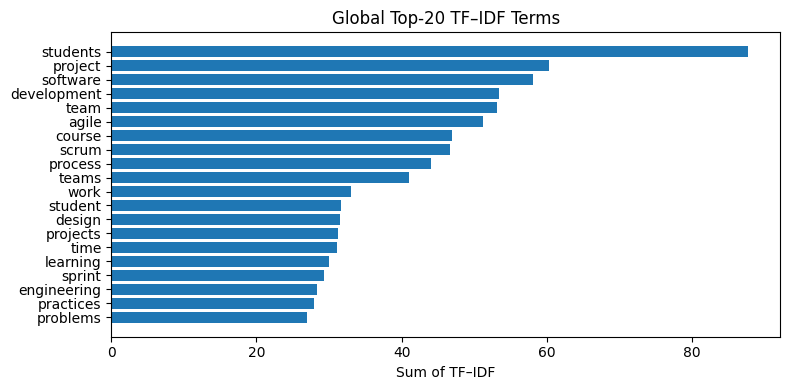

In [15]:
# Fitting TF-IDF on combined to get global vocabulary
tfidf = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)
tfidf_matrix = tfidf.fit_transform(pd.concat([pos_df['cleaned'], neg_df['cleaned']]))

# Sum TF-IDF over documents
term_scores = dict(zip(tfidf.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))
top_terms = sorted(term_scores.items(), key=lambda x: x[1], reverse=True)[:20]
terms, scores = zip(*top_terms)

# Bar chart of top terms
plt.figure(figsize=(8,4))
plt.barh(terms[::-1], scores[::-1])
plt.title('Global Top-20 TF–IDF Terms')
plt.xlabel('Sum of TF–IDF')
plt.tight_layout()
plt.savefig('tfidf_top_terms.png')

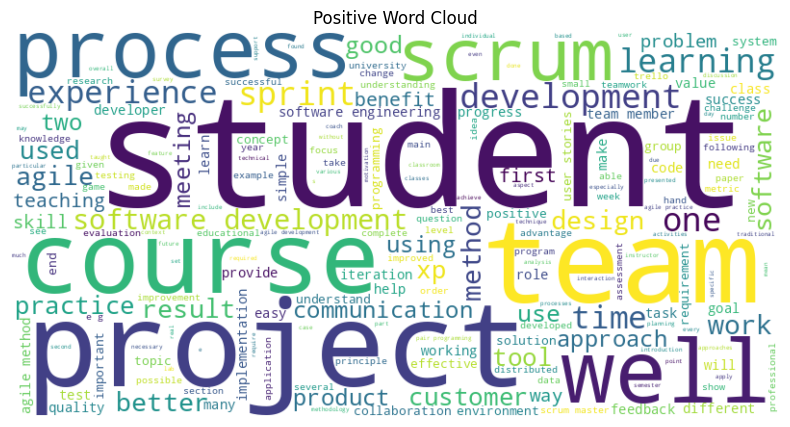

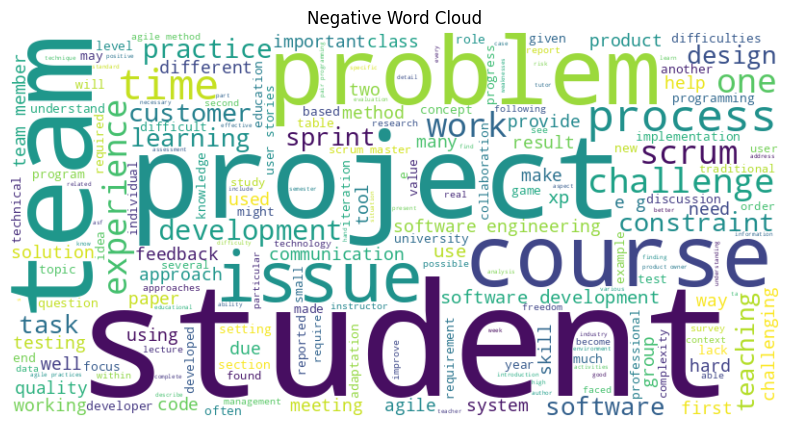

In [16]:
for label, df in [('Positive', pos_df), ('Negative', neg_df)]:
    text = ' '.join(df['cleaned'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{label} Word Cloud')
    plt.savefig(f'{label.lower()}_wordcloud.png')

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF–IDF vectorizers
tfidf_pos = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)
tfidf_neg = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)

X_pos = tfidf_pos.fit_transform(pos_df['cleaned'])
X_neg = tfidf_neg.fit_transform(neg_df['cleaned'])


## LDA Topic Modeling

In [31]:
# Use count vectors for LDA
def fit_lda(df, n_topics=5):
    cv = CountVectorizer(stop_words='english', max_df=0.9, min_df=2)
    Xc = cv.fit_transform(df['cleaned'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(Xc)
    vis = pyLDAvis.lda_model.prepare(lda, Xc, cv)
    pyLDAvis.save_html(vis, f"lda_{df.name}.html")
    return lda, cv

pos_df.name='pos'
neg_df.name='neg'
lda_pos, cv_pos = fit_lda(pos_df, n_topics=5)
lda_neg, cv_neg = fit_lda(neg_df, n_topics=5)

## K-Means Clustering

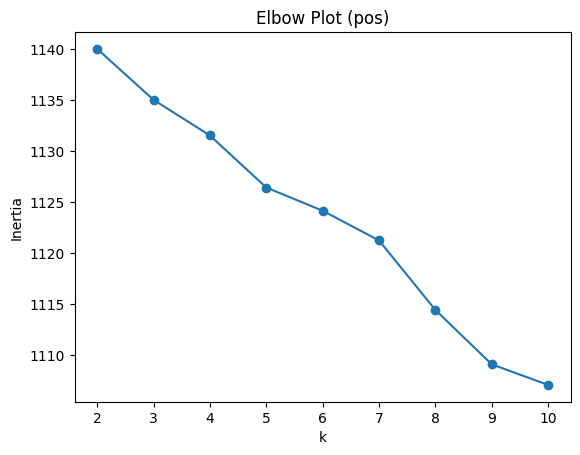

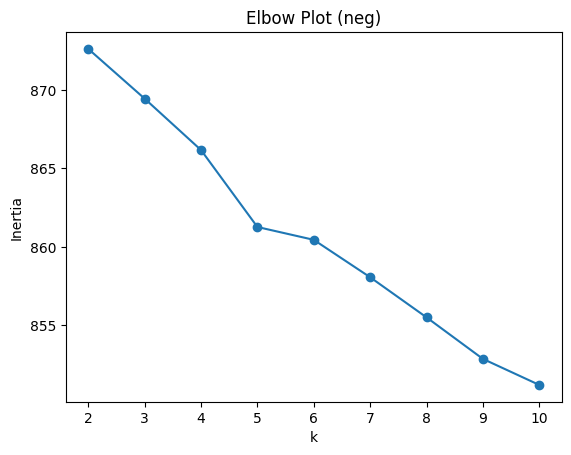

In [32]:
# Elbow method for k selection
def plot_elbow(X, max_k=10, prefix='pos'):
    inertias = []
    Ks = range(2, max_k+1)
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=0).fit(X)
        inertias.append(km.inertia_)
    plt.figure()
    plt.plot(Ks, inertias, 'o-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Plot ({prefix})')
    plt.savefig(f'elbow_{prefix}.png')

plot_elbow(X_pos, max_k=10, prefix='pos')
plot_elbow(X_neg, max_k=10, prefix='neg')

# Fit final clustering (k=5)
km_pos = KMeans(n_clusters=5, random_state=0).fit(X_pos)
pos_df['Cluster'] = km_pos.labels_
km_neg = KMeans(n_clusters=5, random_state=0).fit(X_neg)
neg_df['Cluster'] = km_neg.labels_

## Cluster Visualization (t-SNE & PCA)


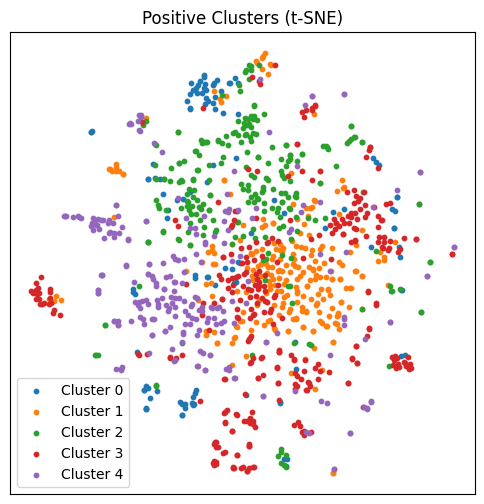

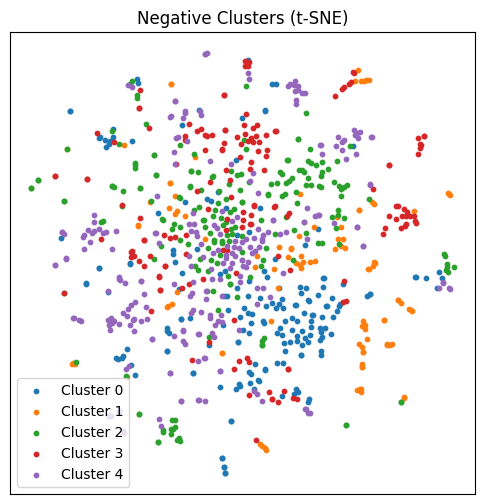

In [33]:

# Dimensionality reduction + scatter
def plot_embedding(X, labels, title, prefix):
    # PCA to 50D, then t-SNE to 2D for speed
    pca = PCA(n_components=50, random_state=0)
    X_pca = pca.fit_transform(X.toarray())
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(X_pca)
    plt.figure(figsize=(6,6))
    for cluster in set(labels):
        idx = labels == cluster
        plt.scatter(X_tsne[idx,0], X_tsne[idx,1], label=f'Cluster {cluster}', s=10)
    plt.legend()
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.savefig(f'{prefix}_tsne.png')

plot_embedding(X_pos, pos_df['Cluster'].values, 'Positive Clusters (t-SNE)', 'pos')
plot_embedding(X_neg, neg_df['Cluster'].values, 'Negative Clusters (t-SNE)', 'neg')



## Topic Interpretation & Detailed Category Labeling

In [34]:
import numpy as np

def top_topic_words(lda_model, vectorizer, n_top=10):
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for i, comp in enumerate(lda_model.components_):
        top_indices = comp.argsort()[-n_top:][::-1]
        topics[i] = [feature_names[idx] for idx in top_indices]
    return topics

# LDA top words
pos_topics = top_topic_words(lda_pos, cv_pos)
neg_topics = top_topic_words(lda_neg, cv_neg)
print("Positive LDA Topics:", pos_topics)
print("Negative LDA Topics:", neg_topics)

# K-Means top TF-IDF terms per cluster
def top_cluster_terms(km, vectorizer, n_top=10):
    """
    km           : trained KMeans model (e.g. km_pos)
    vectorizer   : the TfidfVectorizer instance used to create X_pos
    n_top        : how many top terms per cluster to return
    """

    feature_names = vectorizer.get_feature_names_out()      # length must match centroid dims
    centroids     = km.cluster_centers_                     # shape: (n_clusters, n_features)

    clusters = {}
    for i, centroid in enumerate(centroids):
        # finding the indices of the top-n features for this centroid
        top_indices = centroid.argsort()[-n_top:][::-1]
        # mapping those indices to actual terms
        clusters[i] = [feature_names[idx] for idx in top_indices]
    return clusters



pos_cluster_terms = top_cluster_terms(km_pos, tfidf_pos, n_top=10)
neg_cluster_terms = top_cluster_terms(km_neg, tfidf_neg, n_top=10)

print("Positive Cluster Terms:", pos_cluster_terms)
print("Negative Cluster Terms:", neg_cluster_terms)


# Inspecting a few sample passages for each cluster
for i in range(5):
    print(f"Positive Cluster {i} Samples:")
    print(pos_df[pos_df['Cluster']==i]['cleaned'].sample(3).values)
    print(f"Negative Cluster {i} Samples:")
    print(neg_df[neg_df['Cluster']==i]['cleaned'].sample(3).values)

Positive LDA Topics: {0: ['students', 'agile', 'design', 'based', 'course', 'development', 'project', 'scrum', 'learning', 'engineering'], 1: ['software', 'development', 'projects', 'agile', 'easy', 'tools', 'real', 'actors', 'r2', 'quality'], 2: ['students', 'project', 'scrum', 'team', 'software', 'agile', 'sprint', 'development', 'course', 'product'], 3: ['process', 'software', 'development', 'students', 'method', 'project', 'team', 'projects', 'programming', 'metrics'], 4: ['students', 'teams', 'student', 'team', 'project', 'communication', 'good', 'work', 'programming', 'scrum']}
Negative LDA Topics: {0: ['team', 'project', 'issues', 'sprint', 'students', 'stories', 'user', 'teams', 'issue', 'scrum'], 1: ['software', 'students', 'agile', 'development', 'process', 'course', 'practices', 'challenges', 'engineering', 'scrum'], 2: ['students', 'problems', 'scrum', 'project', 'constraints', 'team', 'time', 'programming', 'communication', 'meetings'], 3: ['students', 'software', 'project

In [38]:
cluster_to_category_pos = {
    0: "User-Centered Design & Real-World Value",
    1: "Active & Experiential Learning",
    2: "Effective Agile Team Collaboration",
    3: "Agile Design Thinking & Quality Engineering",
    4: "Structured Agile Practices in Course Projects"
}

cluster_to_category_neg = {
    0: "Overcomplex Engineering & Process Rigidity",
    1: "Time, Team & Technical Constraints",
    2: "Scrum Misunderstandings & Role Confusion",
    3: "Curriculum Integration & Teaching Method Gaps",
    4: "Design Estimation & Scope Misalignment"
}

# Apply mappings
pos_df['Category'] = pos_df['Cluster'].map(cluster_to_category_pos)
neg_df['Category'] = neg_df['Cluster'].map(cluster_to_category_neg)


## Temporal Trend Analysis and Visualization


/tmp/ipython-input-41-3367704716.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pos_trends = pos_df.groupby(['YearGroup','Category']).size().unstack(fill_value=0)
/tmp/ipython-input-41-3367704716.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  neg_trends = neg_df.groupby(['YearGroup','Category']).size().unstack(fill_value=0)


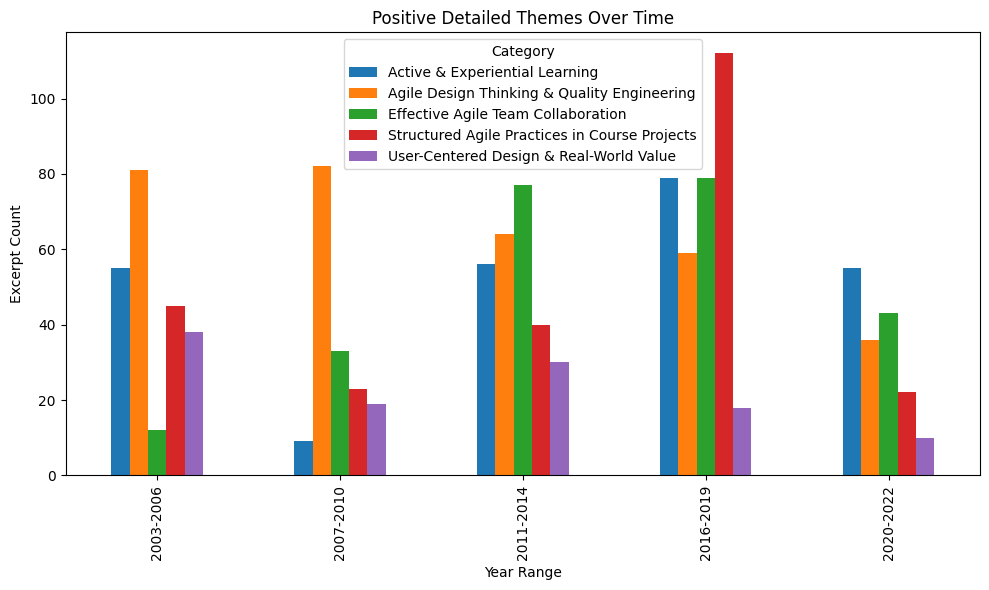

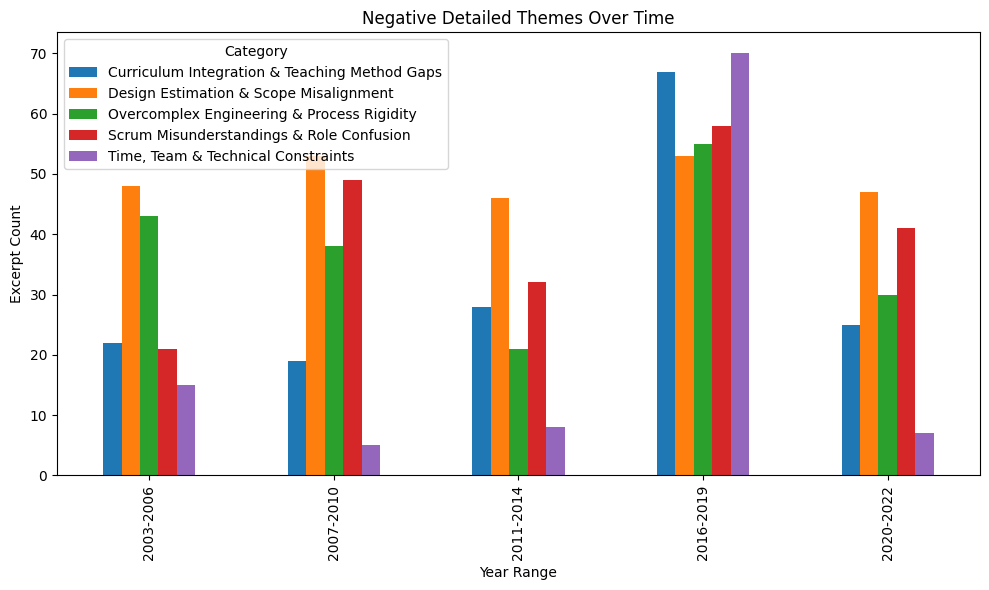

In [41]:
# Count by YearGroup and Category
pos_trends = pos_df.groupby(['YearGroup','Category']).size().unstack(fill_value=0)
neg_trends = neg_df.groupby(['YearGroup','Category']).size().unstack(fill_value=0)

# Plot positive detailed trends
pos_trends.plot(kind='bar', figsize=(10,6))
plt.title('Positive Detailed Themes Over Time')
plt.ylabel('Excerpt Count')
plt.xlabel('Year Range')
plt.tight_layout()
plt.savefig('positive_detailed_trends.png')

# Plot negative detailed trends
neg_trends.plot(kind='bar', figsize=(10,6))
plt.title('Negative Detailed Themes Over Time')
plt.ylabel('Excerpt Count')
plt.xlabel('Year Range')
plt.tight_layout()
plt.savefig('negative_detailed_trends.png')

## Saving results

In [44]:
# Saving the fully annotated dataframes
pos_df.to_csv('positive_categorized_detailed.csv', index=False)
neg_df.to_csv('negative_categorized_detailed.csv', index=False)